In [3]:
import cv2
import numpy as np
import os
from typing import Union
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
def crop(im, bbox):
    return im[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2], :]

In [5]:
# video_file = r"C:\Fotos y videos\test distant cars\distant_car_1.mp4"
video_file = r"C:\Fotos y videos\test SfM\video2.mp4"

video = cv2.VideoCapture(video_file)

delta_t = 1000/25
 # ms

In [6]:
ret = True
current_time_ms = 0

images_list = []
while ret:
    video.set(cv2.CAP_PROP_POS_MSEC, current_time_ms)
    ret, frame = video.read()
    key = cv2.waitKey(0)
    if key == 27 or ret is False:
        break
    cv2.imshow('press esc to stop', frame)
    images_list.append(cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb))
    current_time_ms += delta_t

cv2.destroyAllWindows()

# Select ROI

In [7]:
# Select ROI
roi = cv2.selectROI(cv2.cvtColor(images_list[0], cv2.COLOR_YCrCb2BGR))
cv2.destroyAllWindows()
# print(roi)

# Crop images
cropped_images_list = []
for im in images_list:
    im_resized = crop(im, roi)
    cropped_images_list.append(im_resized)



In [8]:
# Display cropped images
cv2.namedWindow('press enter to follow, esc to stop', cv2.WINDOW_KEEPRATIO)
for im in cropped_images_list:
    cv2.imshow('press enter to follow, esc to stop', cv2.cvtColor(im, cv2.COLOR_YCrCb2BGR))
    key = cv2.waitKey(0)
    if key == 27:
        break

cv2.destroyAllWindows()

# Select template

In [12]:
# Select template
cv2.namedWindow("select template", cv2.WINDOW_KEEPRATIO)
template_bbox = cv2.selectROI("select template", cv2.cvtColor(cropped_images_list[0], cv2.COLOR_YCrCb2BGR))
cv2.destroyAllWindows()

template = cropped_images_list[0][template_bbox[1]:template_bbox[1]+template_bbox[3],
                                  template_bbox[0]:template_bbox[0]+template_bbox[2], :]


## Template matching

In [13]:
im = cropped_images_list[0]

def template_matching(im, template):
    tm = cv2.matchTemplate(im, template, method=cv2.TM_CCOEFF_NORMED)
    ax1_max_indices = np.argmax(tm, axis=1) # max index of each row
    partial_max = np.array([tm[i, ax1_max_indices[i]] for i in range(tm.shape[0])])
    ax0_max_ind = np.argmax(partial_max) # max index of max col
    center = (ax1_max_indices[ax0_max_ind], ax0_max_ind)
    tm_bbox = (center[0], 
            center[1], 
            template.shape[1], template.shape[0])
    return tm_bbox

In [14]:
n_upsample = 8
images_to_register_list = []
for im in cropped_images_list:
    image_to_register = crop(im, template_matching(im, template))
    image_to_register = cv2.resize(image_to_register, 
    (image_to_register.shape[1]*n_upsample, image_to_register.shape[0]*n_upsample))
    cv2.namedWindow("If you don't like, press Esc", cv2.WINDOW_FREERATIO)
    cv2.imshow("If you don't like, press Esc", cv2.cvtColor(image_to_register, cv2.COLOR_YCrCb2BGR))
    key = cv2.waitKey(0)
    if key == 27:
        break
    else:
        images_to_register_list.append(image_to_register)
    
cv2.destroyAllWindows()

# Register images to the first one

### Registering function

In [30]:
def register_im1_to_im2(img_color_1: np.array, img_color_2: np.array, ratio_th: float = 0.75,
                        verbose: bool = False):
    """
    Assumes images are YCrCb.
    """
    img1 = img_color_1[:,:,0]
    img2 = img_color_2[:,:,0]

    # Create SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    # Create a matcher
    bf = cv2.BFMatcher()

    # Match descriptors
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_th * n.distance:
            good_matches.append(m)

    if len(good_matches) == 0:
        print("Not eough good matches")
        cv2.destroyAllWindows()
        return None
    # Draw matches on images
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Display the result
    cv2.namedWindow('Initially found matches', cv2.WINDOW_NORMAL)
    cv2.imshow('Initially found matches', img_matches)

    # Extract matched keypoints
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    try:
        # Use RANSAC to estimate the transformation matrix
        transformation_matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        if verbose:
            print('Transformation matrix:')
            print(transformation_matrix)
        # Draw matches on images excluding outliers
        good_matches_outlier_removed = np.array(good_matches)[mask.ravel() == 1]
        img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, 
                                    good_matches_outlier_removed, 
                                    None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        win = cv2.namedWindow('Matches after reprojection iterations', cv2.WINDOW_NORMAL)
        cv2.imshow('Matches after reprojection iterations', img_matches)

        # Apply the transformation to image1
        registered_img_color_1 = cv2.warpPerspective(img_color_1, transformation_matrix, (img_color_2.shape[1], img_color_2.shape[0]))
        cv2.namedWindow("If you don't like, press Esc", cv2.WINDOW_KEEPRATIO)
        cv2.imshow("If you don't like, press Esc", cv2.cvtColor(registered_img_color_1, cv2.COLOR_YCrCb2BGR))
        key = cv2.waitKey(0)
        cv2.destroyAllWindows()
    except:
        cv2.destroyAllWindows()
        return None

    if key == 27:
        return None
    else:
        return registered_img_color_1

## Batch registering

In [31]:
registered_images = []
for im in images_to_register_list:
    reg_im = register_im1_to_im2(im, images_to_register_list[0])
    if reg_im is not None:
        registered_images.append(reg_im)
    else:
        break

In [32]:
for im in registered_images:
    cv2.namedWindow("registered image", cv2.WINDOW_KEEPRATIO)
    cv2.imshow('registered image', cv2.cvtColor(im, cv2.COLOR_YCrCb2BGR))
    cv2.waitKey(0)
cv2.destroyAllWindows()

## Mean of registered images

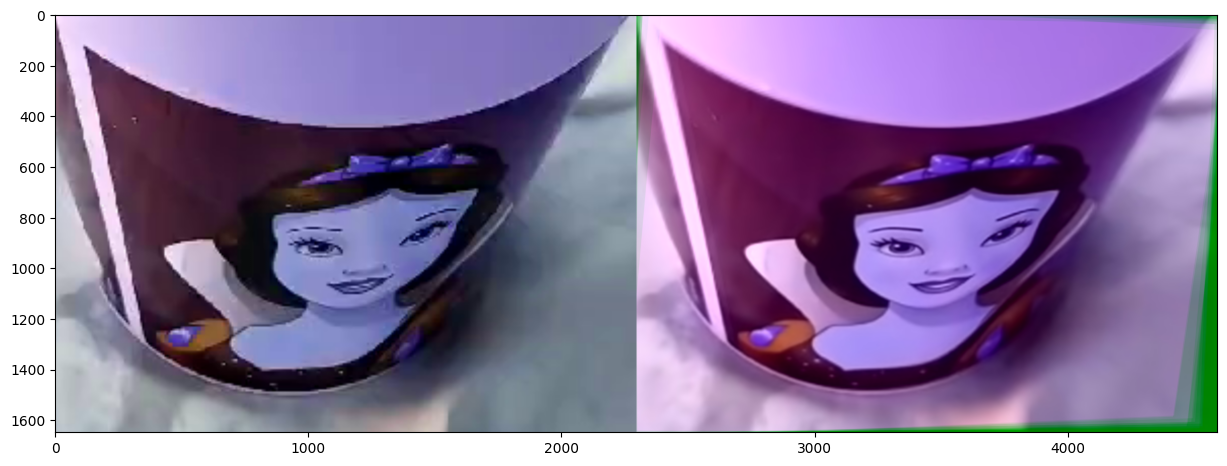

In [33]:
registered_images_float = np.array(registered_images, dtype='float')
mean_image = np.mean(registered_images_float, axis=0)
mean_image -= np.min(mean_image)
mean_image /= np.max(mean_image)
mean_image *= 255
mean_image = mean_image.astype('uint8')
plt.figure(figsize=(15, 30))
plt.imshow(cv2.cvtColor(np.hstack((images_to_register_list[0], mean_image)), cv2.COLOR_YCrCb2BGR))
plt.show()

## Median of registered images

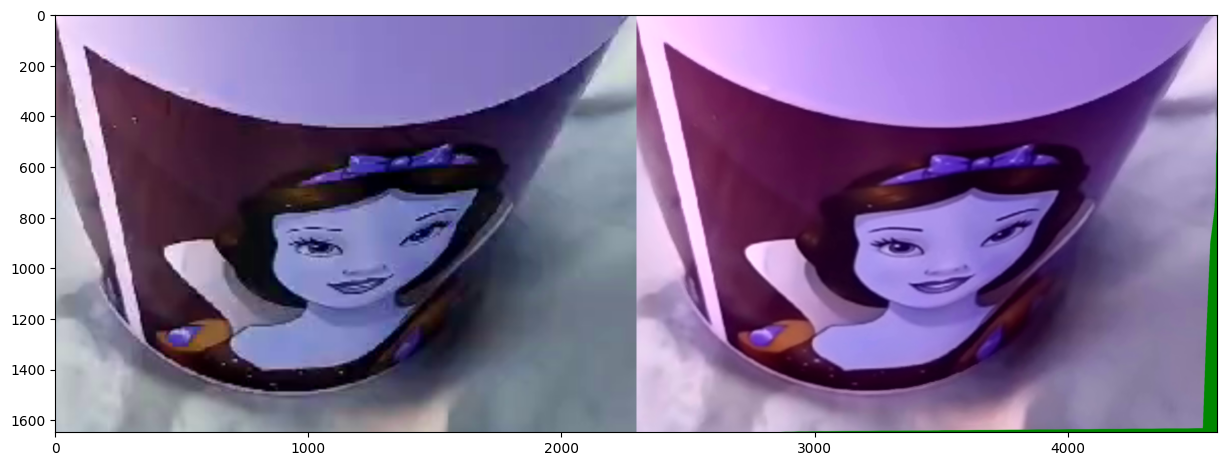

In [34]:
registered_images_float = np.array(registered_images, dtype='float')
median_image = np.median(registered_images_float, axis=0)
median_image -= np.min(median_image)
median_image /= np.max(median_image)
median_image *= 255
median_image = median_image.astype('uint8')
plt.figure(figsize=(15, 30))
plt.imshow(cv2.cvtColor(np.hstack((images_to_register_list[0], median_image)), cv2.COLOR_YCrCb2BGR))
plt.show()

In [35]:
cv2.destroyAllWindows()